
Este exemplo foi inspirado no exemplo 4.2.2 do livro (Lewis; Nithiarasu;Seetharamu,2004), cujo título é: Fundamentals of the finite element method for heat and fluid flow.

O intuito aqui é expor a implementação de um caso simples, que seja transiente.


In [1]:
# Importar a biblioteca do Firedrake.

try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake


--2024-08-29 14:53:04--  https://fem-on-colab.github.io/releases/firedrake-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4581 (4.5K) [application/x-sh]
Saving to: ‘/tmp/firedrake-install.sh’

/tmp/firedrake-inst 100%[===================>]   4.47K  --.-KB/s    in 0s      

2024-08-29 14:53:04 (40.8 MB/s) - ‘/tmp/firedrake-install.sh’ saved [4581/4581]

+ INSTALL_PREFIX=/usr/local
++ awk -F/ '{print NF-1}'
++ echo /usr/local
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FIREDRAKE_INSTALLED=/usr/local/share/fem-on-colab/firedrake.installed
+ [[ ! -f /usr/local/share/fem-on-colab/firedrake.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/db5ca88/rele

/usr/local/lib/python3.10/dist-packages/pytools/persistent_dict.py:59: UserWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "


In [2]:
import os

os.environ["OMP_NUM_THREADS"] = "1" # Isso é solicitado no manual do Firedrake, para que o mesmo não apresente os alertas que poderão ocorrer com o OMP.


In [3]:
import matplotlib.pyplot as plt
from firedrake import *
import numpy as np

In [4]:
num_elements = 4 # Quantidade de elementos que serão usadas nesta malha;
mesh = IntervalMesh(num_elements, 0.0, 0.03) # Armazenamento da malha unidimensional com os elementos definidos na variável num_elements.
x, = mesh.coordinates # Definir x como coordenada da malha.

In [5]:
degree = 1 # Grau do polinômio;
V = FunctionSpace(mesh, "CG", degree) # "CG" denota os elementos finitos Lagrangeanos.

In [6]:
u_new = Function(V)

u_old = Function(V)

v = TestFunction(V) # Função peso;


In [7]:
# Evolução Temporal:

Dt = 0.01

In [8]:
# Definir as constantes que serão usadas no PV:

k = Constant(21)
G = Constant(0.3 * 10**6)
A = Constant(1)
dt = Constant(Dt)

a = (inner(1/dt * (u_new - u_old), v) * dx) +  (k * A * inner(grad(u_new), grad(v))) * dx - (G * v * dx)

In [9]:
c1 = DirichletBC(V, 40, 2) # Condição de contorno do lado direito, representado por 2.

In [10]:
# Para a inicialização do Solver, temos:

solver_parameters = {
    'mat_type': 'aij',
    'snes_type': 'newtonls', # Define um método não-linear.
    "pc_type": "lu"
}

In [11]:
problem = NonlinearVariationalProblem(a, u_new, bcs = c1)

solver = NonlinearVariationalSolver(problem, solver_parameters=solver_parameters)

In [12]:
i = 0
t = 0
Total_time = 1
solution_values = np.zeros(num_elements+1) # Matriz que receberá a solução do PV.

norma = 1 # Qualquer valor maior que a tolerância

tolerance = 1.e-3

while t < Total_time and norma > tolerance:
  print(f'{i}\t= Passo de tempo')

  solver.solve()

  norma = norm(u_new - u_old)

  u_old.assign(u_new) # Atualiza u_old com o novo;

  i += 1

  t += Dt # próxima iteração

  vetor = assemble(u_new).dat.data # Variável para receber a mudança do objeto do Firedrake em um vetor

  for k in range(num_elements+1): # Substitui a cada passo de tempo os valores da solução, pois temos interesse somente no último resultado.
    solution_values[k] = vetor[k]



0	= Passo de tempo
1	= Passo de tempo
2	= Passo de tempo


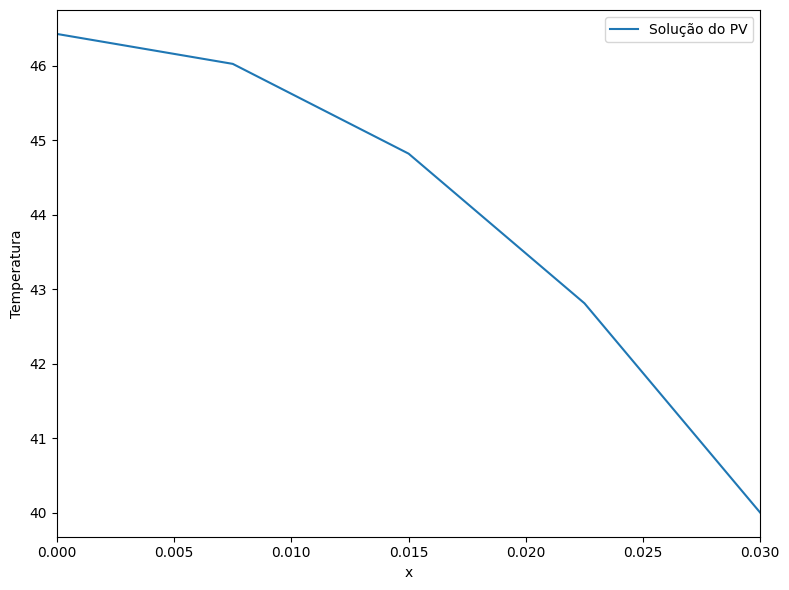

In [13]:
x_values = assemble(x).dat.data # Coordenada x em vetor


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)


ax.plot(x_values, solution_values, label='Solução do PV')

ax.set_xlabel('x')
ax.set_ylabel('Temperatura')

ax.legend(loc='best')

plt.show()
